<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
display (data.describe(include='all'))

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
print(data.isnull().sum())

num_orders    0
dtype: int64


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
 data_resampled = data.resample('1H').sum()

In [8]:
data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
print(data_resampled.isnull().sum())

num_orders    0
dtype: int64


В первом пункте произведена загрузка данных, проверены пропуски, сделан первичный анализ данных.

1. Среднее количество заказов такси за 10 минут - 14.
2. Медианное значение - 13 заказов
3. Максимальное кол-во заказов за 10 минут - 119.
4. Сделано ресемплирование по 1 часу.

## Анализ

In [10]:
display (data_resampled.describe(include='all'))

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [11]:
print(data_resampled.duplicated().sum())

4165


In [12]:
print(data_resampled.isnull().sum())

num_orders    0
dtype: int64


Дубликаты связаны с тем, что несколько заказов такси были сделаны в одно и то же время время, поэтому удалять дубликаты нет смысла.

Сделаю анализ по заказам по часам и по дням неделям.

In [13]:
data_resampled['hour'] = data_resampled.index.hour
data_resampled['day_of_week'] = data_resampled.index.dayofweek

In [14]:
hour_data = data_resampled.groupby('hour')['num_orders'].mean()

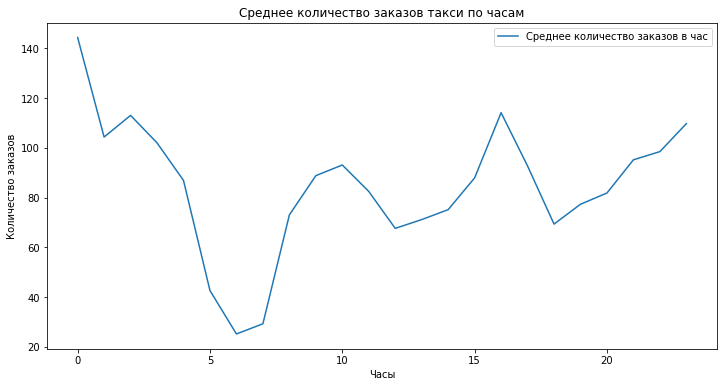

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(hour_data, label='Среднее количество заказов в час')
plt.title('Среднее количество заказов такси по часам')
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [16]:
day_data = data_resampled.groupby('day_of_week')['num_orders'].mean()

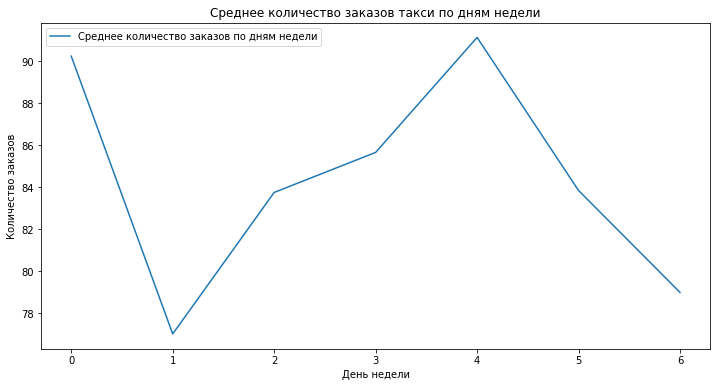

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(day_data, label='Среднее количество заказов по дням недели')
plt.title('Среднее количество заказов такси по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Делаю декомпозицию временного ряда с указанием периода в 24 часа и проведение функции для визуализации компонентов декомпозиции.

In [18]:
decomposition_result = seasonal_decompose(data_resampled['num_orders'], period=24)

In [19]:
def plot_decomposition(component, style, color, title):
    plt.style.use(style)
    plt.figure(figsize=(14, 4))
    component.plot(ax=plt.gca(), color=color)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.title(title)
    plt.show()

Визуализация тренда

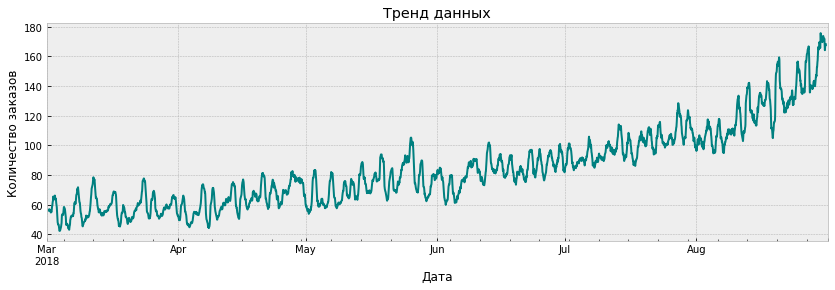

In [20]:
plot_decomposition(
    decomposition_result.trend,
    'bmh',
    'teal',
    'Тренд данных'
)

Визуализация сезонности

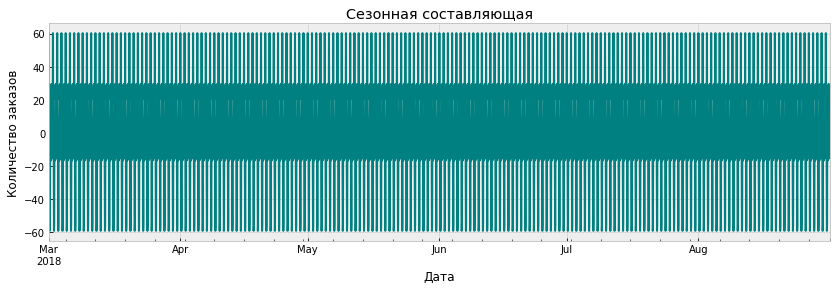

In [21]:
plot_decomposition(
    decomposition_result.seasonal,
    'bmh',
    'teal',
    'Сезонная составляющая'
)

Визуализация остатка

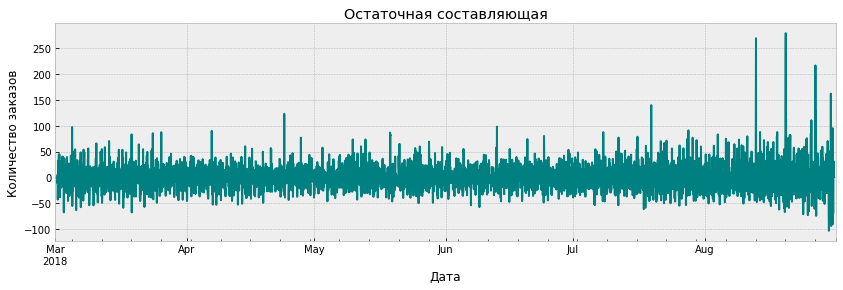

In [22]:
plot_decomposition(
    decomposition_result.resid,
    'bmh',
    'teal',
    'Остаточная составляющая'
)

Минимальное количество заказов в час - 0, максимальное - 465, медиана - 78, среднее количество заказов - 84.

Самое большое количество заказов наблюдается в 23:00-00:00, когда могут заканчиваться ночные мероприятия, например, концерты и прочее. Также пик заказов наблюдается в 17-18:00, когда люди возвращаются с работы. Минимальное количество заказов приходится на 4-6 утра.

Самый высокий спрос наблюдается в понедельник и четверг-пятницу. Во вторник минимальное количество заказов. Также спрос снижается на выходных.

## Обучение

Создаю признаки для обучения модели

In [23]:
max_lag = 24
rolling_mean_size = 48

In [24]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

make_features(data_resampled, 'num_orders', max_lag, rolling_mean_size)

data_resampled = data_resampled.dropna()

Разделяю данные на тестовую и обучающую выборку

In [25]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1, random_state=1515)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [26]:
categorical_features = ['hour', 'day_of_week']
encoder = OneHotEncoder(drop='first', sparse=False)

Модели, которые буду использовать для обучения

In [27]:
models = {
    "Линейная регрессия": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=1515),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=1515),
    "LGBM": LGBMRegressor(random_state=1515)
}

In [28]:
param_grids = {
    "Decision Tree": {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    "CatBoost": {
        'iterations': [100, 200],
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.1]
    },
    "LGBM": {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }
}

In [29]:
best_model = None
best_score = float('inf')
for model_name, model in models.items():
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        pipeline = Pipeline(steps=[
            ('encoder', ColumnTransformer(transformers=[('cat', encoder, categorical_features)], remainder='passthrough')),
            ('model', grid_search)
        ])
        pipeline.fit(features_train, target_train)
        score = mean_squared_error(target_train, pipeline.predict(features_train), squared=False)
        print(f"Модель: {model_name}, Лучшие параметры: {grid_search.best_params_}, Лучшая оценка кросс-валидации (RMSE): {score}")
        if score < best_score:
            best_score = score
            best_model = pipeline
    else:
        pipeline = Pipeline(steps=[
            ('encoder', ColumnTransformer(transformers=[('cat', encoder, categorical_features)], remainder='passthrough')),
            ('model', model)
        ])
        pipeline.fit(features_train, target_train)
        score = mean_squared_error(target_train, pipeline.predict(features_train), squared=False)
        print(f"Модель: {model_name}, Оценка на обучающей выборке (RMSE): {score}")
        if score < best_score:
            best_score = score
            best_model = pipeline

Модель: Линейная регрессия, Оценка на обучающей выборке (RMSE): 22.802163392156896
Модель: Decision Tree, Лучшие параметры: {'max_depth': 10, 'min_samples_split': 20}, Лучшая оценка кросс-валидации (RMSE): 18.95614481560399
Модель: CatBoost, Лучшие параметры: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}, Лучшая оценка кросс-валидации (RMSE): 16.857263534523415
Модель: LGBM, Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}, Лучшая оценка кросс-валидации (RMSE): 12.532709710018016


На обучающей выборке модели показали следующие результаты:

Линейная регрессия (RMSE): 22,80

Дерево решений (RMSE): 18.96

{'max_depth': 10, 'min_samples_split': 20}

CatBoost (RMSE): 16,86

{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

LGBM: 12,53

{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}

На тестовой выборке будет использовано LGBM

## Тестирование

In [30]:
test_predictions = best_model.predict(features_test)
test_score = mean_squared_error(target_test, test_predictions, squared=False)
print(f"Оценка на тестовой выборке (RMSE): {test_score}")

Оценка на тестовой выборке (RMSE): 41.377560113588636


Условия задания выполнеы

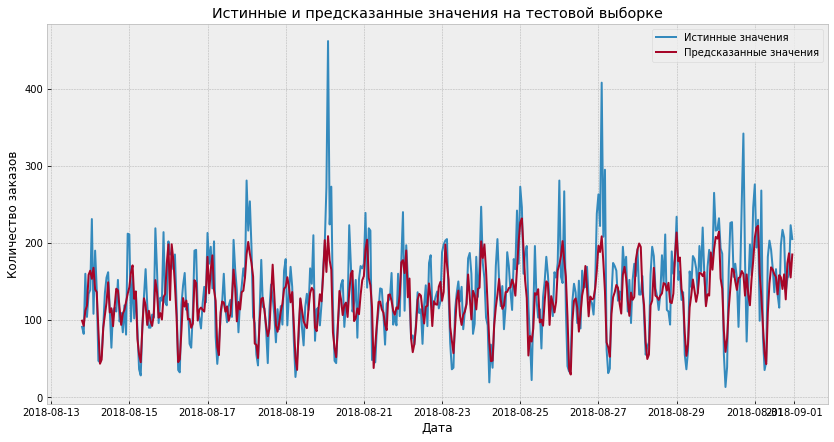

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(target_test.index, target_test, label='Истинные значения')
plt.plot(target_test.index, test_predictions, label='Предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Истинные и предсказанные значения на тестовой выборке')
plt.legend()
plt.show()

На графике видно, что модель хорошо делает предсказания количества заказов такси, но есть отклонения, которые могли быть вызваны какими-то событиями, которые невозможно предугадать. 

Полученная модель на тестовой выборке показывает суточные колебания в спросе на ьтакси, в том числе уменьшение и увеличение заказов, поэтому справляется с поставленной задачей хорошо.